<a href="https://colab.research.google.com/github/germanjke/Global_Wheat_Detection/blob/master/boxes_cleaning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import os

from tqdm.auto import tqdm
import shutil as sh
import torch
import random

import cv2
import matplotlib.pyplot as plt

In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


**Загрузка датасета, преобразование**

In [ ]:
df = pd.read_csv('/content/drive/My Drive/GWD/global-wheat-detection/train.csv')
bboxs = np.stack(df['bbox'].apply(lambda x: np.fromstring(x[1:-1], sep=',')))

for i, column in enumerate(['x', 'y', 'w', 'h']):
    df[column] = bboxs[:,i]
df.drop(columns=['bbox'], inplace=True)
df['x_center'] = df['x'] + df['w']/2
df['y_center'] = df['y'] + df['h']/2
df['classes'] = 0

df = df[['image_id','x', 'y', 'w', 'h', 'x_center', 'y_center', 'classes']]

In [ ]:
df.head()

,image_id,x,y,w,h,x_center,y_center,classes
0,b6ab77fd7,834.0,222.0,56.0,36.0,862.0,240.0,0
1,b6ab77fd7,226.0,548.0,130.0,58.0,291.0,577.0,0
2,b6ab77fd7,377.0,504.0,74.0,160.0,414.0,584.0,0
3,b6ab77fd7,834.0,95.0,109.0,107.0,888.5,148.5,0
4,b6ab77fd7,26.0,144.0,124.0,117.0,88.0,202.5,0


**Работа с боксами**

In [ ]:
print('Мы имеем ' + str(len(df.image_id)) + ' боксов и ' + str(len(df.image_id.unique())) + ' уникальных картинок')

Мы имеем 147793 боксов и 3373 уникальных картинок


In [ ]:
#подсчёт площади каждого бокса
w_list = df.w.to_list()
h_list = df.h.to_list()
area_list = [w*h for w,h in zip(w_list,h_list)]

In [ ]:
#добавим площадь в датасет
df['area'] = area_list

In [ ]:
print('Выведем среднее значение и стандартное отклоненение: ')
print('mean=%.3f stdv=%.3f' % (np.mean(area_list), np.std(area_list)))

Выведем среднее значение и стандартное отклоненение: 
mean=6843.357 stdv=5876.307


In [ ]:
print('Боксов с большой площадью: ' , len(df[df['area'] >= 100000]))

Боксов с большой площадью:  24


In [ ]:
len(df[df['area'] >= 75000])

52

In [ ]:
big_boxes = df.image_id[df.area >= 75000].tolist() #обозначим список больших боксов по айди картинки 

In [ ]:
big_boxes_indexes = df[df.area >= 75000].index.tolist() #обозначим список больших боксов по индексу

**Функция для показа боксов на картинке по её айди**

In [ ]:
def show_bboxes(index):

  boxes = df.iloc[index][['x','y','w','h']].values
  img_id = df.image_id[df.index == index].tolist()[0]

  img = cv2.imread(os.path.join('/content/drive/My Drive/GWD/global-wheat-detection/train', img_id + '.jpg'), cv2.IMREAD_COLOR)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
  img /= 255.0

  boxes[2] = boxes[0] + boxes[2] # x2 = x1 + w
  boxes[3] = boxes[1] + boxes[3] # y2 = y1 + h

  labels = torch.ones((boxes.shape[0], ), dtype=torch.int64)
  target = {}
  target['boxes'] = boxes
  target['labels'] = labels
  target['image_id'] = torch.tensor(0)

  img = torch.tensor(img)

  boxes = target['boxes'].astype(np.int32)
  np_img = img.cpu().numpy()
  #np_img = img.permute(1, 2, 0).cpu().numpy()
  print(np_img.shape)

  fig, ax = plt.subplots(1, 1, figsize=(16, 8))
  cv2.rectangle(np_img, (boxes[1], boxes[0]), (boxes[3], boxes[2]), (0, 1, 0), 3) # start, end points / try to fix

  ax.set_axis_off()
  ax.imshow(np_img)
  plt.show()

(1024, 1024, 3)


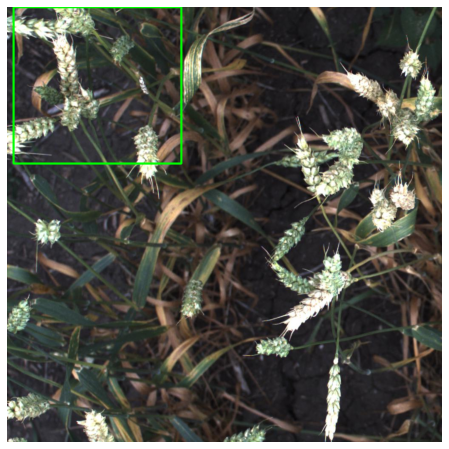

In [ ]:
show_bboxes(big_boxes_indexes[0]) #проверим работу на первом элементе

In [ ]:
for x in big_boxes_indexes: #выведем все
  show_bboxes(x) #это выведет нам поочередно 52 элемента из нашего списка

**Функция для удаления того, что нам не нужно**

In [ ]:
indexes_to_delete = [] #сюда будут сохраняться удаленные индексы
def del_box(index):
  show_bboxes(index)
  print('Delete this box from dataset?')
  input_text = input('Type y or n: ')
  if input_text == 'y':
    indexes_to_delete.append(index)
  if input_text == 'n':
    pass
  

(1024, 1024, 3)


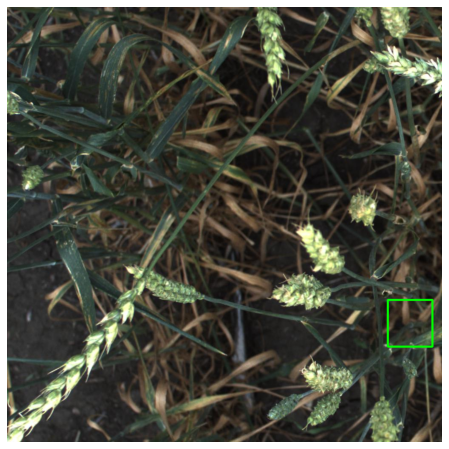

Delete this box from dataset?
Type y or n: y


In [ ]:
del_box(big_boxes_indexes[1]) #единичный пример

In [ ]:
for x in big_boxes_indexes: #запустим, это выведет нам все 52 элемента из списка
  del_box(x)

In [ ]:
df.drop(df.index[big_boxes_indexes])